In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import sys
model_dir = '/homes/okz21/NNC/models/'
import models
from utils import test_accuracy, train_epoch, show_weights, layer_utils, print_dims
import copy

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
plt.rcParams['text.color'] = 'white'

#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

num_epochs = 100
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_full = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
use_cuda = torch.cuda.is_available()

## LeNet 300-100

### 1. Train Model

In [2]:
model = models.LeNet_300_100()
print_dims(model)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.000)

model.cuda()
for epoch in range(num_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    accuracy = test_accuracy(test_loader, model)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], accuracy))

300x784 + 300
100x300 + 100
10x100 + 10


NameError: global name 'criterion' is not defined

In [ ]:
torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs))

### 2. Re-train Model

/homes/okz21/.conda/envs/aml/lib/python2.7/site-packages/torch/serialization.py:284: SourceChangeWarning: source code of class 'models.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


(97.53, 1.48663330078125)
(97.76, 1.4923244714736938)


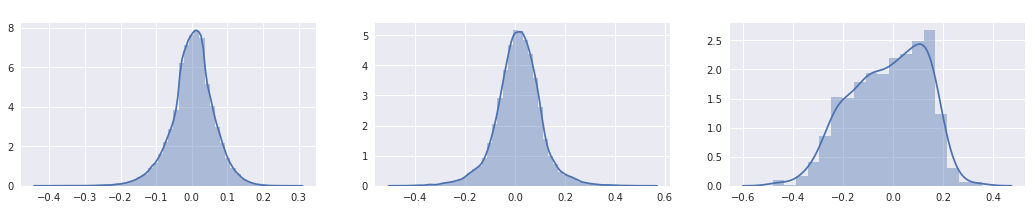

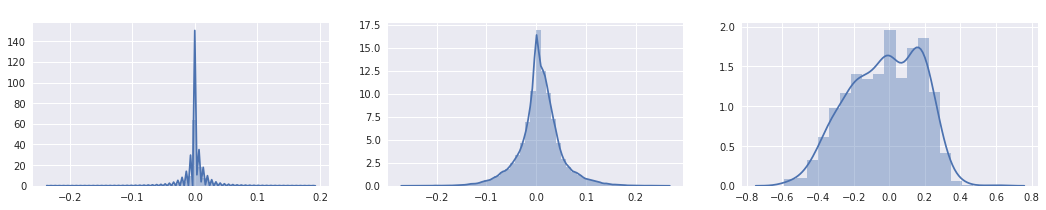

In [2]:
# 1. Load model
# 2. Get new labels, generate new dataset
# 3. New Loss Function
# 4. Freeze Layers
# 5. Train with L2 penalty
# 6. Trim
# 7. Get accuracy

#1 Load Model
model_name = 'LeNet_300_100'
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, num_epochs)).cuda()
model_wd = torch.load(model_dir + 'mnist_{}_{}_wd.m'.format(model_name, num_epochs)).cuda()

print test_accuracy(test_loader, model, get_loss = True)
print test_accuracy(test_loader, model_wd, get_loss = True)

show_weights(model)
show_weights(model_wd)

In [3]:
#2 Get training traget softmaxes
targets_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=False)
for i, (images, labels) in enumerate(targets_loader):
    kd_outputs = model.forward(Variable(images).cuda(),True)

features = torch.zeros(len(train_dataset), train_dataset[0][0].size()[1], train_dataset[0][0].size()[2])
for i in range(0,len(train_dataset)):
    features[i] = train_dataset[i][0][0]
kd_dataset = torch.utils.data.TensorDataset(features, kd_outputs.data)#.data turns variable -> tensor

train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

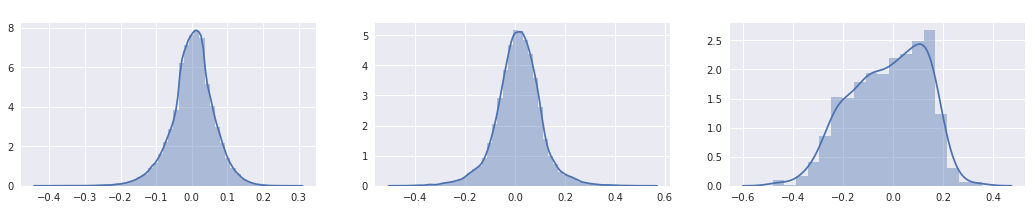

In [4]:
#Load model f
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs)).cuda()
model_kd = models.LeNet_300_100_kd().cuda()
model_kd.load_state_dict(model.state_dict())

criterion_kd = nn.MSELoss()
learning_rate_kd = 0.0005
wd_kd = 0.01
optimizer_kd_1 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
optimizer_kd_2 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
optimizer_kd_3 = torch.optim.Adam(model_kd.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

#show_weights(model)
show_weights(model_kd)

In [20]:
def get_weight_penalty(model):
    wp=0
    for layer in model.state_dict():
        wp += np.sqrt(model.state_dict()[layer].pow(2).sum())
    return wp 

Epoch: 1. Train CE Loss: 0.12718732655, Train Accuracy: 98.9466666667, Test CE Loss: 0.161308318377, Test Accuracy: 97.53, Model L2: 38.9307209151
Epoch: 2. Train CE Loss: 0.12718732655, Train Accuracy: 98.9466666667, Test CE Loss: 0.161308318377, Test Accuracy: 97.53, Model L2: 37.5854471743
Epoch: 3. Train CE Loss: 0.12718732655, Train Accuracy: 98.9466666667, Test CE Loss: 0.161308318377, Test Accuracy: 97.53, Model L2: 36.9776060618
Epoch: 4. Train CE Loss: 0.12718732655, Train Accuracy: 98.9466666667, Test CE Loss: 0.161308318377, Test Accuracy: 97.53, Model L2: 36.5730796838
Epoch: 5. Train CE Loss: 0.12718732655, Train Accuracy: 98.9466666667, Test CE Loss: 0.161308318377, Test Accuracy: 97.53, Model L2: 36.2995296994
Epoch: 6. Train CE Loss: 0.12718732655, Train Accuracy: 98.9466666667, Test CE Loss: 0.161308318377, Test Accuracy: 97.53, Model L2: 36.1107581146
Epoch: 7. Train CE Loss: 0.12718732655, Train Accuracy: 98.9466666667, Test CE Loss: 0.161308318377, Test Accuracy: 97

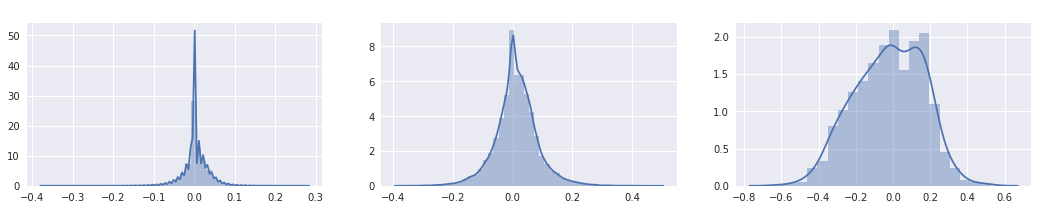

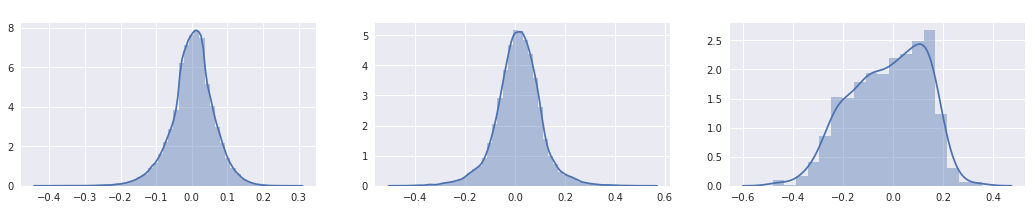

In [21]:
retraining_epochs=20
for epoch in range(retraining_epochs):
    model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader, kd=True)
    model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader, kd=True)
    model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader, kd=True)
    test_acc = test_accuracy(test_loader, model, kd=True, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model, kd=True, get_loss=True)
    weight_penalty = get_weight_penalty(model_kd)
    print('Epoch: {}. Train CE Loss: {}, Train Accuracy: {}, Test CE Loss: {}, Test Accuracy: {}, Model L2: {}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
show_weights(model_kd)
show_weights(model)

In [34]:
torch.save(model_kd, model_dir + 'mnist_{}_{}.m'.format(model_kd.name, retraining_epochs))

In [36]:
class layer_prune():
    def __init__(self, weight):
        self.weight = weight.data.clone()
        self.org_weight = weight.clone()
        self.num_weights = weight.size()[0] * weight.size()[1]
        
        weight_np = np.abs((weight.clone().cpu().numpy()))
        weight_np = weight_np.reshape(-1)
        percentile_limits = [x for x in range (0,101)]
        self.percentile_values = np.percentile(weight_np, percentile_limits)
        
        self.num_pruned = 0
        
    def prune(self, percentile):
        self.weight = self.org_weight.clone()
        zero_idx = self.weight.abs()<self.percentile_values[percentile]
        self.num_pruned = zero_idx.sum()
        self.weight[zero_idx] = 0
        return self.weight
    
    def plot(self):
        plt.clf()
        sns.distplot(self.weight.clone().view(-1).cpu().numpy())
        plt.show()

In [74]:

model_kd = torch.load(model_dir + 'mnist_LeNet_300_100_kd_20.m')
class model_prune():
    def __init__(self, state_dict):
        self.state_dict = state_dict
        self.std = {}
        self.mean = {}
        self.num_weights = {}
        self.percentile_limits = {}
        self.prune_list = [x for x in self.state_dict.keys() if 'weight' in x]
        for layer in self.state_dict:
            self.std[layer] = self.state_dict[layer].std()
            self.mean[layer] = self.state_dict[layer].mean()
            self.num_weights[layer] = 1
            for dim in self.state_dict[layer].size():
                self.num_weights[layer] *= dim
            weight_np = np.abs((self.state_dict[layer].clone().cpu().numpy())).reshape(-1)
            self.percentile_limits[layer] = np.percentile(weight_np, range(0,101))
            
    def percentile_prune(self, percentile):
        new_state_dict = copy.deepcopy(self.state_dict)
        for layer in self.prune_list:
            zero_idx = new_state_dict[layer].abs()<self.percentile_limits[layer][percentile]
            new_state_dict[layer][zero_idx] = 0
        return new_state_dict
    
    def deviation_prune(self, deviation):
        new_state_dict = copy.deepcopy(self.state_dict)
        for layer in self.prune_list:
            zero_idx = (new_state_dict[layer] - self.mean[layer]).abs() < self.std[layer] * deviation
            new_state_dict[layer][zero_idx] = self.mean[layer]
        return new_state_dict
mp = model_prune(model_kd.state_dict())
model_kd.load_state_dict(mp.deviation_prune(2))


-2.4172e-02  6.2203e-02  7.9677e-03  ...   1.2937e-01 -2.8740e-02 -9.3041e-02
 3.9946e-02 -1.9685e-02  4.1524e-02  ...   1.5988e-02 -5.9887e-02  6.0942e-03
-4.9494e-42 -4.4365e-42 -4.0946e-42  ...  -3.7737e-42 -5.9653e-42 -3.6013e-42
                ...                   ⋱                   ...                
 1.0875e-01 -1.8733e-02  8.5076e-02  ...  -2.4242e-02 -6.2422e-02  6.8690e-02
-6.7995e-02  3.7449e-02 -3.4239e-02  ...   1.6877e-02 -7.4819e-02  5.3664e-02
 1.1951e-01  8.7359e-02  4.1538e-02  ...   7.9285e-02  8.7545e-02  4.2314e-03
[torch.cuda.FloatTensor of size 100x300 (GPU 0)]

0.0122831612825

-3.6455e-02  4.9920e-02 -4.3154e-03  ...   1.1709e-01 -4.1023e-02 -1.0532e-01
 2.7663e-02 -3.1968e-02  2.9241e-02  ...   3.7047e-03 -7.2170e-02 -6.1889e-03
-1.2283e-02 -1.2283e-02 -1.2283e-02  ...  -1.2283e-02 -1.2283e-02 -1.2283e-02
                ...                   ⋱                   ...                
 9.6469e-02 -3.1016e-02  7.2793e-02  ...  -3.6525e-02 -7.4706e-02  5.6407e